In [2]:
from dense import Dense
from activations import *
import numpy as np
from losses import mse, mse_prime

import bisect
from sklearn import preprocessing
import os
import pandas as pd
from parameters import *
import copy
import regex as re
import matplotlib.pyplot as plt


In [3]:
os.chdir('C:\\Users\\91993\\Desktop\\chaos\\')

In [4]:
home_path = os.getcwd()
saved_path = home_path
saved_path

'C:\\Users\\91993\\Desktop\\chaos'

In [5]:
initialization_list = [1,2,3,4]

In [6]:
df_train = {f'train{initialization}':[] for initialization in initialization_list}
df_test = {f'test{initialization}':[] for initialization in initialization_list}

In [12]:
for init in initialization_list:
    home_path = saved_path
    os.chdir(home_path)
    path = home_path+'\\NN-RESULTS-FINAL\\datasets'
    datasets_path = os.path.join(path,"data")
    init_path = os.path.join(path,"initializations")
    os.chdir(datasets_path)


    datasets = os.listdir()

    #-----------------------------control------------------------------#
    data_curr = "sonar"
    initialization = init
    new_init = True
    #------------------------------------------------------------------#


    #----------------------------------------------------------------------------------------#
    init_path = os.path.join(path,"initializations")
    path_initializations = f'{init_path}\\{data_curr}'
    try:
        list_init = os.listdir(path_initializations)
    except:
        os.mkdir(path_initializations)
        list_init = os.listdir(path_initializations)

    numbers = []

    print(list_init)

    for items in list_init:
        if(re.search(f'{data_curr}',items)):
            str_temp = items.split("-")[1]
            numbers.append(int(str_temp.split(".")[0]))




    if numbers.__contains__(initialization) and new_init:
        new_init = False
        print("initialization already exists")
    else:
        if len(numbers)==0:
            initialization = 1
        else:
            initialization = numbers[-1]+1


    params = parameter_file(data_curr,path,initialization,new_init)

    lr = params['learning_rate'] 
    epochs = params['num_epochs'] 
    loss = globals()[params['loss']]
    loss_prime = globals()[params['loss']+'_prime']
    network = params['network']
    start_weights = params['init']

    X_train,Y_train,X_test,Y_test = params['data']


    num_dense = 0
    for items in network:
        if items.__class__.__name__ == 'Dense':
            num_dense +=1
        
    if new_init:
        init_path = os.path.join(path,"initializations")
        try:
            os.mkdir(f'{init_path}\\{data_curr}')

        except:
            print("")

        path_new_init = f'{init_path}\\{data_curr}\\{data_curr}-{initialization}.npy'
        np.save(path_new_init,start_weights)

    #---------------------------------------------------------------------------------------#
    list_w = []
    list_b = []

    weights_per_layer = []

    for items in network:
        if items.__class__.__name__ == 'Dense':
            weights_per_layer.append(items.weights.shape[0]*items.weights.shape[1])


    sum_ = weights_per_layer[0]
    for i in range(1,len(weights_per_layer)):
        sum_ += weights_per_layer[i]
        weights_per_layer[i] = sum_



    def visualize_weights(network):
        for items in network:
            if items.__class__.__name__ == 'Dense':
                print(items.weights)
                print(items.bias)


    def mask_weights(mask_list,weights_per_layer):
        if len(mask_list)!=0:
            for mask in mask_list:
                index = bisect.bisect_left(weights_per_layer,mask)
                shape_ = network[2*index].weights.shape


                if index!=0:
                    mask = mask - weights_per_layer[index-1]


                network[2*index].weights[(mask-1)//shape_[1]][(mask-1)%shape_[1]] = 0




    def predict(network, input,store_weights=False):
        output = input
        for layer in network:
            if layer.__class__.__name__ =='Dense' and store_weights==True:
                output = layer.forward(output)
                list_w.append(np.copy(layer.weights))
                list_b.append(np.copy(layer.bias))
            else :
                output = layer.forward(output)


        return output

    def get_accuracy(X_t,Y_t):
        correct = 0
        for x, y in zip(X_t, Y_t):
            output = predict(network, x,store_weights=False)
            if np.argmax(output)==np.argmax(y):
                correct +=1

        return correct

    def train(network, loss, loss_prime, x_train, y_train,x_test,y_test, epochs = 1000, learning_rate = 0.01, verbose = True,store_weights=False,mask_weight=False,mask_list=[],weights_per_layer=[]):
        test_acc = []
        train_acc = []
        for e in range(epochs):
            error = 0
            for x, y in zip(x_train, y_train):
                # forward
                if mask_weight:
                    mask_weights(mask_list=mask_list,weights_per_layer=weights_per_layer)
                    
                output = predict(network, x,store_weights=False)
                # print(output)
                # print(y)
                # print("")
                # error
                error += loss(y, output)

                # backward
                grad = loss_prime(y, output)
                for layer in reversed(network):
                    grad = layer.backward(grad, learning_rate)

                

                if store_weights:
                    train_accuracy = get_accuracy(x_train,y_train)
                    accuracy = get_accuracy(x_test,y_test)
                    test_acc.append(accuracy/x_test.shape[0])
                    train_acc.append(train_accuracy/x_train.shape[0])

            if store_weights!=True:
                train_accuracy = get_accuracy(x_train,y_train)
                accuracy = get_accuracy(x_test,y_test)
                test_acc.append(accuracy/x_test.shape[0])
                train_acc.append(train_accuracy/x_train.shape[0])
                    
            error /= len(x_train)
            if verbose:
                print(f"{e + 1}/{epochs}, error={error}")
            

        return train_acc,test_acc

    visualize_weights(network=network)   
   
    train_acc,test_acc  = train(network, loss,loss_prime,X_train,Y_train,X_test,Y_test,epochs=epochs,learning_rate=lr,verbose=False,store_weights=True,mask_weight=False)
    df_train[f'train{initialization}'] = train_acc
    df_test[f'test{initialization}'] = test_acc
    dftrain = pd.DataFrame(df_train[f'train{initialization}'])
    dftest = pd.DataFrame(df_test[f'test{initialization}'])
    dftrain.to_csv(f'train_accuracy{initialization}.csv',index=False,header=False)
    dftest.to_csv(f'test_accuracy{initialization}.csv',index=False,header=False)


['diabetes-1.npy', 'diabetes-2.npy', 'diabetes-3.npy', 'diabetes-4.npy', 'weight_profiles', 'window_le']
initialization already exists
[[ 0.94314475  0.5356019   0.5990729  -0.97008442  1.97140045 -0.81301386
   0.50763141 -0.85973351]
 [-1.09199837 -0.19097031  0.12009554 -0.08324957  0.10650477  1.36165548
   0.27217857  0.66454626]
 [-0.04057685  0.70877653  0.0600324   0.74119949 -0.24555447 -0.58357314
  -0.35737735  0.06201541]
 [-0.55313193  2.50163079  0.03954052 -0.64640851 -0.97675848  0.1839509
  -0.20749603 -1.4433532 ]
 [-1.64842082 -0.42741787  0.22560017 -2.07888891 -1.47311506  0.36902406
  -0.32090551  0.04181902]]
[[-0.97341753]
 [-0.31754946]
 [ 0.14918768]
 [ 0.1990374 ]
 [-0.5567325 ]]
[[-0.9707893   0.51668725 -1.4883404   0.84671528 -0.43958678]
 [ 0.18440194 -0.59637009  0.40094575 -0.05100352 -0.31156619]]
[[1.8866854 ]
 [0.08718843]]
['diabetes-1.npy', 'diabetes-2.npy', 'diabetes-3.npy', 'diabetes-4.npy', 'weight_profiles', 'window_le']
initialization already 

In [ ]:



def visualize_weights(network):
    for items in network:
        if items.__class__.__name__ == 'Dense':
            print(items.weights)
            print(items.bias)


def mask_weights(mask_list,weights_per_layer):
    if len(mask_list)!=0:
        for mask in mask_list:
            index = bisect.bisect_left(weights_per_layer,mask)
            shape_ = network[2*index].weights.shape


            if index!=0:
                mask = mask - weights_per_layer[index-1]


            network[2*index].weights[(mask-1)//shape_[1]][(mask-1)%shape_[1]] = 0




def predict(network, input,store_weights=False):
    output = input
    for layer in network:
        if layer.__class__.__name__ =='Dense' and store_weights==True:
            output = layer.forward(output)
            list_w.append(np.copy(layer.weights))
            list_b.append(np.copy(layer.bias))
        else :
            output = layer.forward(output)


    return output

def get_accuracy(X_t,Y_t):
    correct = 0
    for x, y in zip(X_t, Y_t):
        output = predict(network, x,store_weights=False)
        if np.argmax(output)==np.argmax(y):
            correct +=1

    return correct

def train(network, loss, loss_prime, x_train, y_train,x_test,y_test, epochs = 1000, learning_rate = 0.01, verbose = True,store_weights=False,mask_weight=False,mask_list=[],weights_per_layer=[]):
    test_acc = []
    train_acc = []
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            if mask_weight:
                mask_weights(mask_list=mask_list,weights_per_layer=weights_per_layer)
                
            output = predict(network, x,store_weights=store_weights)
            # print(output)
            # print(y)
            # print("")
            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

            

            if store_weights:
                train_accuracy = get_accuracy(x_train,y_train)
                accuracy = get_accuracy(x_test,y_test)
                test_acc.append(accuracy/x_test.shape[0])
                train_acc.append(train_accuracy/x_train.shape[0])

        if store_weights!=True:
            train_accuracy = get_accuracy(x_train,y_train)
            accuracy = get_accuracy(x_test,y_test)
            test_acc.append(accuracy/x_test.shape[0])
            train_acc.append(train_accuracy/x_train.shape[0])
                
        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

    return train_acc,test_acc      
    


In [47]:
init = 5
def visualize(train_acc,test_acc):
    plt.plot(train_acc[:])
    plt.plot(test_acc[:])
    plt.legend(['train','test'])
    plt.show()




KeyError: 'train5'

In [ ]:

dict_w = {k:[] for k in range(num_dense)}
dict_b = {k:[] for k in range(num_dense)}

for weights in range(len(list_w)):
    dict_w[weights%num_dense].append(list_w[weights])

for bias in range(len(list_b)):
    dict_b[bias%num_dense].append(list_b[bias])

for key in dict_w.keys():
    for items in range(len(dict_w[key])):
        dict_w[key][items] = dict_w[key][items].reshape(1,-1)[0]

for key in dict_w.keys():
    for items in range(len(dict_w[key])):
        dict_w[key][items] = dict_w[key][items].reshape(1,-1)[0]

df_weights = pd.DataFrame(dict_w[0])

for keys in range(1,num_dense):
    df = pd.DataFrame(dict_w[keys])
    df_weights = pd.concat([df_weights,df],axis=1)

total_weights = df_weights.shape[1]
new_axis = [k for k in range(total_weights)]
df_weights.set_axis(new_axis,axis=1,inplace=True)


mis_class = [1-testacc for testacc in test_acc]
file_str = f'{path_initializations}\\weight_profiles\\{data_curr}-{initialization}_weights.csv'
try:
    df_weights.to_csv(file_str,index=False,header=False)
except:
    os.mkdir(f'{path_initializations}\\weight_profiles')
    df_weights.to_csv(file_str,index=False,header=False)




In [15]:
df_test.keys()

dict_keys(['test1', 'test2', 'test3', 'test4'])

In [61]:

initialization = 2
mis_class = [1-testacc for testacc in df_test[f'test{initialization}']]
##-----------------------------##
file_str = f'{path_initializations}\\weight_profiles\\{data_curr}-{initialization}_weights.csv'
window_size = 200
overlap = 0.1

index_val = int(window_size*(1-overlap))
num_iterates = len(mis_class)//index_val
##-----------------------------##




curr_dir = os.getcwd()
matlab_dir = home_path+'\\NN-RESULTS-FINAL\\scripts\\matlab\\tisean package\\TISEAN_3.0.0-windows\\Tisean_3.0.0\\bin'
os.chdir(matlab_dir)

wpath = home_path+f"\\NN-RESULTS-FINAL\\datasets\\initializations\\{data_curr}\\window_le"

matlab_script = fr'''
close all;
clear all;
                                %make folder from here onwards --> and
                                %the following string should be the same
                                %across all systems wherever it is
                                %supposed to be used


wpath = "{wpath}";




fullFileName = "{file_str}";


data = csvread(fullFileName);
samp = size(data,2);

LE = [];
  csvfilename = "\\window_LE_"+num2str({initialization})+".csv";
  for m = 1:samp
      timeseries = data(:,m);
      le = [];
      for i = 0:{num_iterates-1}
        x = timeseries({index_val}*i+1:{index_val}*(i+1)+{window_size*overlap});
        y = L_E(x);
    
        M = Slope(y);
        lslope = verify(M,i);
   
  
        le = [le,lslope];
                
      end
        LE = [LE;le];
  end
    csvwrite(wpath+csvfilename,LE);






function y = L_E(x)
    
    x=x';
    y = [];
    y=y';
    fid=fopen('logi1.dat','wt');
    fprintf(fid,'%f\n',x);
    fclose(fid);

    system('lyap_r -m2 -r20 -d1 -s20 -V0 -o logi1_lyap.dat logi1.dat');
    y=load('logi1_lyap.dat');

end

function M = Slope(y1)
    y_1 = interp1(y1(:,1),y1(:,2),[1 2.5],'linear');
    y_2 = interp1(y1(:,1),y1(:,2),[0.75 1],'linear');
    y_3= interp1(y1(:,1),y1(:,2),[0.5 0.6],'linear');
    y_4= interp1(y1(:,1),y1(:,2),[0.25 0.75],'linear');
    
    slope1 = (y_1(2)-y_1(1))/(2.5-1);
    slope2 = (y_2(2)-y_2(1))/(1-0.75);
    slope3 = (y_3(2)-y_3(1))/(0.6-0.5);
    slope4 = (y_4(2)-y_4(1))/(.75-.25);
    
    M = [slope1 , slope2,  slope3 , slope4];

end

function lslope = verify(M,i)
    M = round(M,6);
    if (M(2) == M(3))
        lslope = M(2);
    elseif  ( M(3) == M(4)|| M(2) == M(4))
        lslope = M(4);  
    else
        lslope = 0;  
        disp("Slope not matching at "+i);
    end
end



'''

f = open("window_LE.m", "w")
f.write(matlab_script)
f.close()

r = 1
r = os.system(r"matlab -nodisplay -nosplash -nodesktop -r run('window_LE.m'); exit;")



In [54]:
initialization = 1
curr_file = f'{path_initializations}\\window_le\\window_LE_{initialization}.csv'
try:
    le = np.genfromtxt(curr_file,delimiter=',')
except:
    os.mkdir(f'{path_initializations}\\window_le')
    le = np.genfromtxt(curr_file,delimiter=',')


le = le.T
df = pd.DataFrame(le)


In [55]:


from statsmodels.tsa.stattools import grangercausalitytests
mis_class = [1-testacc for testacc in df_test[f'test{initialization}']]
mis_risk = []

for i in range(num_iterates):
    r = index_val*(i+1) + int((window_size*overlap))
    mis_risk.append(mis_class[r-1])

maxlag = 20
pval = []
test = 'ssr_chi2test'

for c in df.columns:
    df1 = pd.DataFrame([mis_risk,df.iloc[:,c].values])
    df1 = df1.T
    non_zero = df1[1].count()
    df1 = df1.iloc[:non_zero]
    test_result = grangercausalitytests(df1[[0,1]], maxlag=20, verbose=False)
    p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
    f_values = [round(test_result[i+1][0][test][0],4) for i in range(maxlag)]
    min_p_value = np.min(p_values)
    pval.append(min_p_value)
pval = np.asarray(pval)
mask = np.where(pval>=0.05)[0]+1
mask_list = mask.tolist()


In [44]:
new_init

False

In [56]:
params = parameter_file(data_curr,path,initialization,new_init)

lr = params['learning_rate'] 
epochs = params['num_epochs'] 
loss = globals()[params['loss']]
loss_prime = globals()[params['loss']+'_prime']
network = params['network']
start_weights = params['init']


In [57]:

network = initialize_Weights(network,params['init'])
train_sparse, test_sparse = train(network, loss,loss_prime,X_train,Y_train,X_test,Y_test,epochs=epochs,learning_rate=lr,verbose=False,store_weights=False,mask_weight=True,mask_list=mask_list,weights_per_layer=weights_per_layer)
network = initialize_Weights(network,params['init'])
train_acc, test_acc = train(network, loss,loss_prime,X_train,Y_train,X_test,Y_test,epochs=epochs,learning_rate=lr,verbose=False,store_weights=False,mask_weight=False,mask_list=mask_list,weights_per_layer=weights_per_layer)



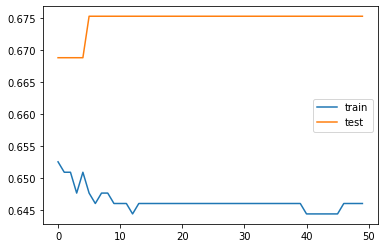

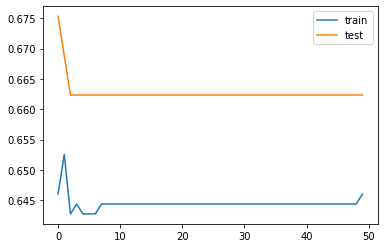

In [48]:
visualize(train_acc,test_acc)
visualize(train_sparse,test_sparse)

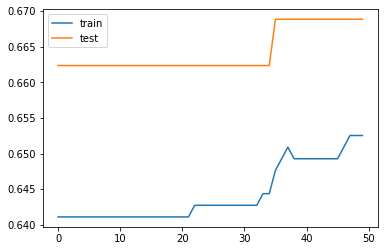

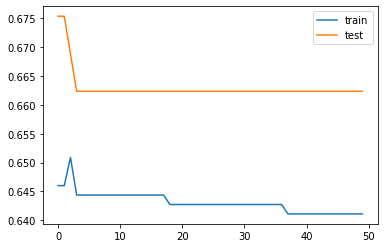

In [53]:
visualize(train_acc,test_acc)
visualize(train_sparse,test_sparse)

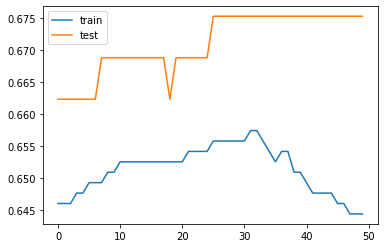

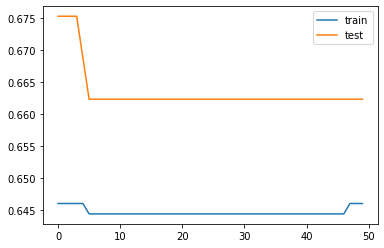

In [60]:
visualize(train_acc,test_acc)
visualize(train_sparse,test_sparse)